# Bias Correction of Climate Model Output over Antarctica using a Bayesian Hierarchical Model and Gaussian Processes

```{contents}
:local:
```
<!-- https://jupyterbook.org/en/stable/structure/configure.html -->

## Introduction

- This notebook focuses on demonstrating some of the key components of a novel approach to bias correcting climate model output using in-situ observations. The approach utilises Gaussian Processes (GPs) and a Bayesian hierarchical framework. Near-surface temperature data is used from automatic weather stations (AWS) over Antarctica to correct an Antarctic-wide climate model simulation.  

- The following paper details the methodology as applied to simulated 1D examples: [Bayesian hierarchical model for bias-correcting climate models](https://doi.org/10.5194/gmd-17-5733-2024). Meanwhile, the work on applying this to real-world surface climatology over Antarctica is ongoing and the code is being developed at the following repository: [Bias Correction Application](https://github.com/Jez-Carter/Bias_Correction_Application.git). Necessary data for this notebook can be found and downloaded from the /walkthrough_tutorial/tutorial_data folder of the repository. 

- Specific mention is given to the Python packages Xarray, Numpryo and TinyGP utilised in this tutorial. Xarray provides a nice way of handling the multidimension data from climate models. Numpyro provides a nice probabilistic programming language for Bayesian statistics. TinyGP provides a nice way of working with and defining Gaussian Processes, also integrating with Numpyro, both of which are built ontop of Jax.    



- The climate model data is available from download from this DOI: https://doi.org/10.5281/zenodo.6367849. While the AWS is available here: https://doi.org/10.48567/key7-ch19. 
- Bias is here defined with respect to the parameters of the PDF for the time series at each location. The AWS output is considered unbiased. The goal is to estimate the unbiased parameter values across the whole domain with an uncertainty, which can then be used to correct the climate model output. To do this generative models are constructed and the underlying spatial covariance structure of the data is considered through GPs.  

## Importing Required Libraries and Loading Data

In [1]:
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import geopandas as gpd
from scipy.spatial import distance
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
import pandas as pd


The data for this tutorial is stored as NetCDF files. This is a common file format for climate model output and is handled well by the Xarray Python package, which can be thought of as a Pandas equivalent for efficient handling of multidimensional data. Xarray loads data as 'datasets' and 'dataarrays'. For specific tasks, such as summarising the data, these Python objects  can be transformed to Pandas 'dataframes'.  

In [2]:
# Loading Data
data_path = '/home/jez/Bias_Correction_Application/walkthrough_tutorial/tutorial_data/'

ds_aws = xr.open_dataset(f'{data_path}ds_aws.nc') # Automatic Weather Station Data
ds_climate = xr.open_dataset(f'{data_path}ds_climate.nc') # Climate Model Data

Xarray allows the data to be rendered and examined as nice interactive tables:

In [3]:
ds_aws

<xarray.Dataset> Size: 925kB
Dimensions:         (station: 219, t: 504)
Coordinates:
  * station         (station) <U22 19kB 'AGO Site' 'AGO-4' ... 'aws16' 'aws17'
    glat            (station) float64 2kB ...
    glon            (station) float64 2kB ...
    grid_latitude   (station) float64 2kB ...
    grid_longitude  (station) float64 2kB ...
    year            (t) float64 4kB ...
    month           (t) float64 4kB ...
  * t               (t) float64 4kB 1.0 2.0 3.0 4.0 ... 501.0 502.0 503.0 504.0
Data variables:
    latitude        (station) float64 2kB ...
    elevation       (station) float64 2kB ...
    temperature     (station, t) float64 883kB ...

In [ ]:
ds_climate

<xarray.Dataset> Size: 45MB
Dimensions:         (time: 456, grid_longitude: 126, grid_latitude: 98)
Coordinates:
  * grid_longitude  (grid_longitude) float64 1kB 152.4 152.9 ... 207.0 207.4
  * grid_latitude   (grid_latitude) float64 784B -21.39 -20.95 ... 20.84 21.29
  * time            (time) datetime64[ns] 4kB 1981-01-31 ... 2018-12-31
    month           (time) int64 4kB ...
    year            (time) int64 4kB ...
    glon            (grid_longitude, grid_latitude) float64 99kB ...
    glat            (grid_longitude, grid_latitude) float64 99kB ...
    t               (time) int64 4kB ...
Data variables:
    temperature     (time, grid_longitude, grid_latitude) float64 45MB ...
    elevation       (grid_longitude, grid_latitude) float64 99kB ...
    latitude        (grid_longitude, grid_latitude) float64 99kB ...

We can convert the Xarray dataset objects to Pandas dataframes if we want to use the describe function from Pandas: 

In [9]:
print('Summary of Automatic Weather Station Data \n',
      ds_aws.to_dataframe().describe()[['elevation','latitude','temperature']])
print('\n Summary of Climate Model Data \n',
      ds_climate.to_dataframe().describe()[['elevation','latitude','temperature']])

Summary of Automatic Weather Station Data 
            elevation       latitude   temperature
count  110376.000000  110376.000000  18088.000000
mean     1251.009132     -76.472009    -25.852952
std      1131.183380       5.411963     14.071861
min         5.000000     -90.000000    -71.740000
25%        87.000000     -79.820000    -31.880000
50%      1122.000000     -76.320000    -24.135000
75%      2090.000000     -73.080000    -16.320000
max      4093.000000     -65.240000      1.750000

 Summary of Climate Model Data 
           elevation      latitude   temperature
count  2.610144e+06  2.610144e+06  2.610144e+06
mean   2.003590e+03 -7.661032e+01 -3.257423e+01
std    1.150357e+03  5.392458e+00  1.458319e+01
min   -3.087963e+00 -8.971554e+01 -7.326862e+01
25%    1.045115e+03 -8.060204e+01 -4.373946e+01
50%    2.192235e+03 -7.646343e+01 -3.125523e+01
75%    2.988649e+03 -7.229835e+01 -2.182017e+01
max    4.063502e+03 -6.397399e+01  1.437534e+00


## Data Exploration

### Weather Station Locations

To provide initial context we'll start by plotting the locations of the weather stations and the grid of the climate model output. 

```{admonition} Note: Coordinate Systems
:class: note
Note that for plotting we use a specific rotated coordinate system (defined below). The `glon' and `glat' fields are in this coordinate system and it was created to get around issues assoicated with plotting the shapefile with longitude flipping between -180 to 180. 
```

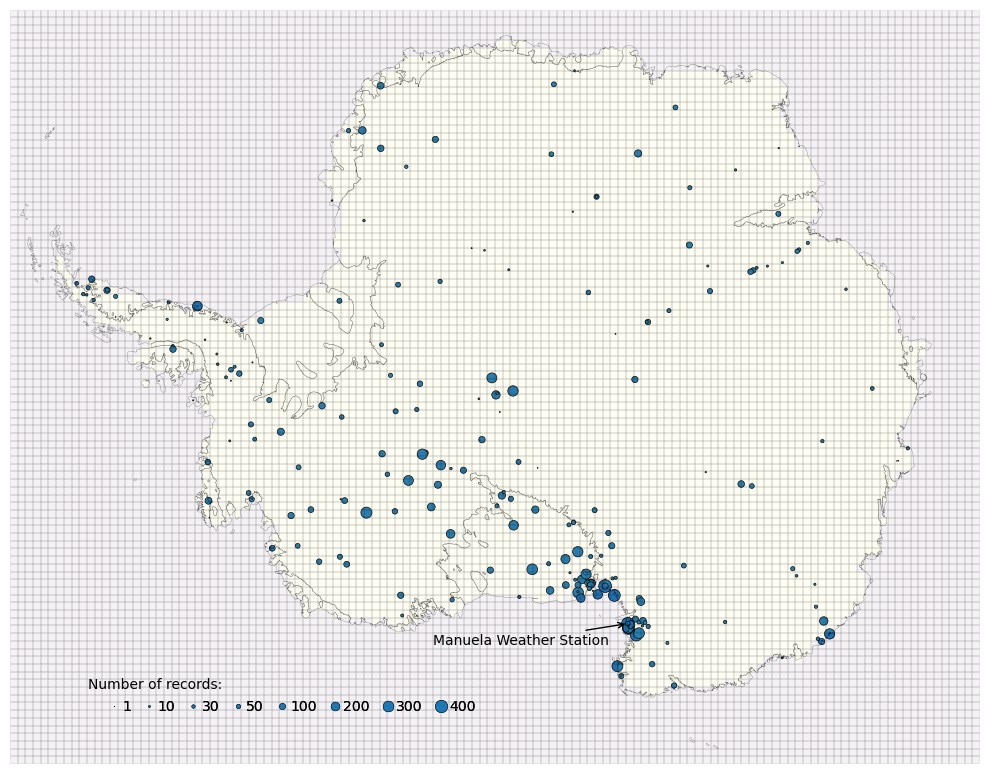

In [8]:
# Loading ice sheet shapefile 
icesheet_shapefile_path = '/home/jez/Bias_Correction_Application/walkthrough_tutorial/tutorial_data/icesheet_shapefile/icesheet.shp'
gdf_icesheet = gpd.read_file(icesheet_shapefile_path)

# Defining rotated coordinate system (glon,glat) and converting ice sheet shapefile to rotated coordinates
rotated_coord_system = ccrs.RotatedGeodetic(
    13.079999923706055,
    0.5199999809265137,
    central_rotated_longitude=180.0,
    globe=None,
)
gdf_icesheet_rotatedcoords = gdf_icesheet.to_crs(rotated_coord_system)

############################################################################################################

# Defining background map function
def background_map_rotatedcoords(ax):
    gdf_icesheet_rotatedcoords.boundary.plot(
        ax=ax,
        color='k',
        linewidth=0.3,
        alpha=0.4)
    ax.set_axis_off()

# Defining marker size legend function
def markersize_legend(ax, bins, scale_multipler, legend_fontsize=10,loc=3,ncols=1,columnspacing=0.8,handletextpad=0.1,bbox=(0.,0.)):
    ax.add_artist(
        ax.legend(
            handles=[
                mlines.Line2D(
                    [],
                    [],
                    color="tab:blue",
                    markeredgecolor="k",
                    markeredgewidth=0.3,
                    lw=0,
                    marker="o",
                    markersize=np.sqrt(b*scale_multipler),
                    label=str(int(b)),
                )
                for i, b in enumerate(bins)
            ],
            loc=loc,
            fontsize = legend_fontsize,
            ncols=ncols,
            columnspacing=columnspacing,
            handletextpad=handletextpad,
            bbox_to_anchor=bbox,
            framealpha=0,
        )
    )

############################################################################################################

# Plotting the weather station locations
fig, ax = plt.subplots(1, 1, figsize=(10, 10),dpi=100)#,frameon=False)
background_map_rotatedcoords(ax)
ax.scatter(
    ds_aws.glon,
    ds_aws.glat,
    s=ds_aws.count('t')['temperature']/5,
    edgecolor='k',
    linewidths=0.5,
)
ax.annotate(
    'Number of records:',
    xy=(0.08, 0.1), xycoords='axes fraction',
    fontsize=10)
markersize_legend(ax, [1,10,30,50,100,200,300,400], scale_multipler=1/5, legend_fontsize=10,loc=3,ncols=9,columnspacing=0.3,handletextpad=-0.4,bbox=(0.08,0.05))

# highlighting individual station
station = 'Manuela'
ax.annotate(
    f'{station} Weather Station',
    xy=(ds_aws.sel(station = station).glon, ds_aws.sel(station = station).glat), xycoords='data',
    xytext=(-140,-15), textcoords='offset points',
    arrowprops=dict(arrowstyle="->"),
    fontsize=10)

# Plotting the climate model grid
ds_climate['temperature'].mean('time').notnull().plot.pcolormesh(
    x='glon',
    y='glat',
    ax=ax,
    alpha=0.05,
    add_colorbar=False,
    edgecolor='k',
    linewidth=0.3,
)

plt.tight_layout()
plt.show()


We can see that the spatial distribution of weather stations is not very uniform. There's clearly a higher density of stations over West Antarctica than East Antarctica and there are certain regions with particularly high density clusters of observations. This is an important consideration and will induce a bias if the spatial distribution is not accounted for. Gaussian processes allow us to consider the spatial covariance between sites and thus partially accounts for the clustered distribution. Note there are potentially location selection biases that can't be accounted for using GPs, such as if many of the sites were chosen specifically because there's a lot of melt recorded nearby and so the temperature is anomalously high.  

### Single Weather Station Time Series and PDF Comparisons

For further context we'll plot the time series for a particular weather station, as well as the time series for the climate model output of the nearest grid-cell. 

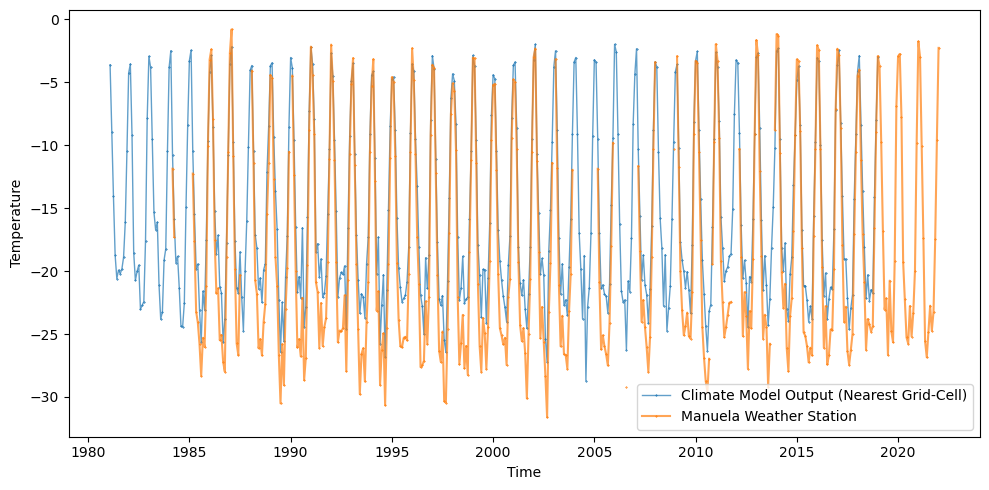

In [10]:
# Computing Nearest Neighbours
ds_climate_stacked = ds_climate.stack(x=('grid_longitude', 'grid_latitude')).dropna('x')
ox = np.dstack([ds_aws['glon'],ds_aws['glat']])[0]
cx = np.dstack([ds_climate_stacked['glon'],ds_climate_stacked['glat']])[0]
nn_indecies = []
for point in ox:
    nn_indecies.append(distance.cdist([point], cx).argmin())
ds_climate_nearest_stacked = ds_climate_stacked.isel(x=nn_indecies)
ds_climate_nearest_stacked = ds_climate_nearest_stacked.assign_coords(nearest_station=("x", ds_aws.station.data))
ds_climate_nearest_stacked = ds_climate_nearest_stacked.swap_dims({"x": "nearest_station"})

# Single Site Full Time Series
fig, ax = plt.subplots(1, 1, figsize=(10, 5), dpi=100)
station = 'Manuela'
ds_climate_nearest_stacked.sel(nearest_station = station)['temperature'].plot(x="t",
                                                                              ax=ax,
                                                                              hue='station',
                                                                              alpha=0.7,
                                                                              label='Climate Model Output (Nearest Grid-Cell)',
                                                                              marker='x',
                                                                              ms=1,
                                                                              color='tab:blue',
                                                                              linewidth=1.0)

ds_aws.sel(station = station)['temperature'].plot(ax=ax,
                                                hue='station',
                                                alpha=0.7,
                                                label=f'{station} Weather Station',
                                                marker='x',
                                                ms=1,
                                                color='tab:orange',
                                                linewidth=1.5)
xticks = np.arange(0,45*12,12*5)
xticklabels = np.arange(1980,2025,5)
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)
ax.set_ylabel('Temperature')
ax.set_xlabel('Time')
ax.legend()
ax.set_title('')
plt.tight_layout()
plt.show()


The Manuela weather station has a comparatively high number of temperature records, which here spans from 1984-2021. The monthly temperature time series is plot and compared against the time series for the climate model output of the nearest grid-cell (which spans from 1981-2019). The variance in the time series are dominated by the seasonal cycle. While there appears to be a bias in the mean between the 2 time series, it's quite likely that this bias depends on the particular season. In this piece of work we define bias as differences in the parameters of the PDF for the 2 time series. The PDFs are plot below for the above time series.

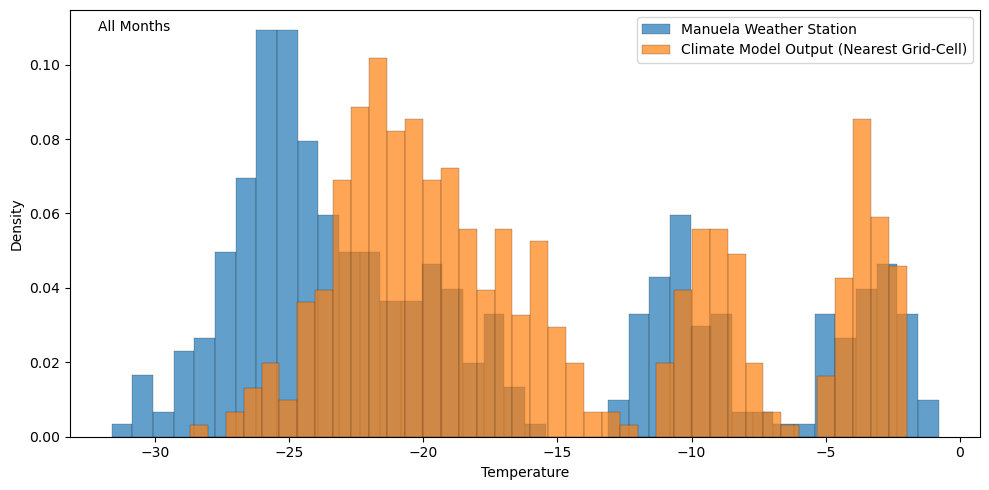

In [11]:
# Probability Density Function (all months)
station = 'Manuela'

fig, ax = plt.subplots(1, 1, figsize=(10, 5), dpi=100)
ds_aws.sel(station=station).to_dataframe()[['temperature']].hist(bins=40,
                                         ax=ax,
                                         edgecolor='k',
                                         linewidth=0.2,
                                         grid=False,
                                         density=1,
                                         alpha=0.7,
                                         label = f'{station} Weather Station',
                                         )
ds_climate_nearest_stacked.sel(nearest_station=station).to_dataframe()[['temperature']].hist(bins=40,
                                         ax=ax,
                                         edgecolor='k',
                                         linewidth=0.2,
                                         grid=False,
                                         density=1,
                                         alpha=0.7,
                                        label = 'Climate Model Output (Nearest Grid-Cell)',
                                         )
ax.annotate('All Months',xy=(0.03,0.95),xycoords='axes fraction')
ax.set_title('')
ax.set_xlabel('Temperature')
ax.set_ylabel('Density')
plt.legend()
plt.tight_layout()
plt.show()


The PDFs for the whole time series are multi-modal, reflecting the seasonality of the data. Many parameters would be required to adequately describe the distribution and it's clear that defining the bias simply in the mean of the whole time series has limited value. For example, while the mean of the winter peak is ~5° higher for the climate model output, the means in the summer peak are approximately equal. While we could aim to parameterise this distribution, a more common approach is simply to split the time series up by the month, focusing on defining bias for each month separately. It is expected that for individual months the PDF will be Gaussian and the bias can be defined in terms of differences in the mean and variance between the in-situ weather station observations and the climate model output. The PDF split by month for the weather station data is shown below: 


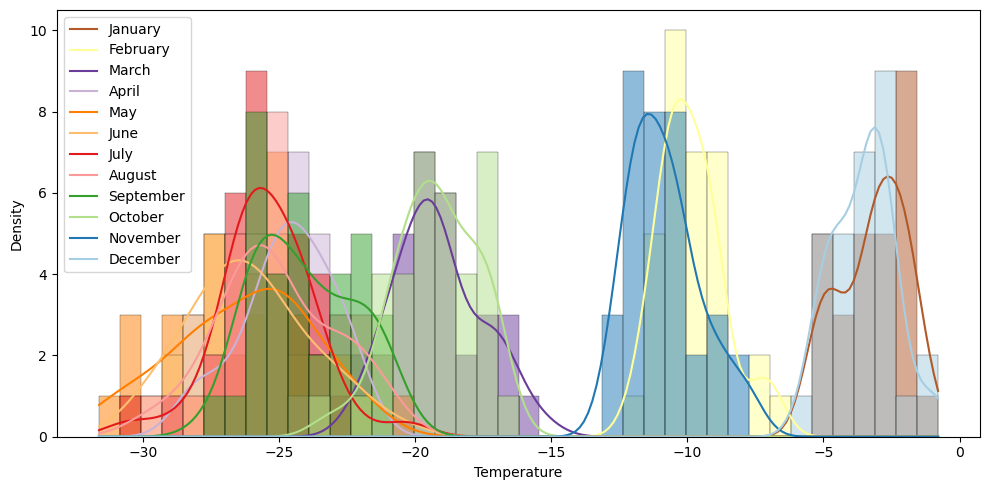

In [12]:
# Probability Density Function by Month
station = 'Manuela'

fig, ax = plt.subplots(1, 1, figsize=(10, 5), dpi=100)

sns.histplot(data=ds_aws.sel(station=station).to_dataframe()[['month','temperature']],
            x='temperature',
            hue='month',
            bins=40,
            ax=ax,
            edgecolor='k',
            linewidth=0.2,
            kde=True,
            palette='Paired',
)

ax.set_title('')
ax.set_xlabel('Temperature')
ax.set_ylabel('Density')
plt.legend(['January','February','March','April','May','June','July','August','September','October','November','December'])
plt.tight_layout()
plt.show()

Taking just the month of June, the comparison between the time series for the Manuela weather station and climate model output of the nearest grid-cell are shown below:

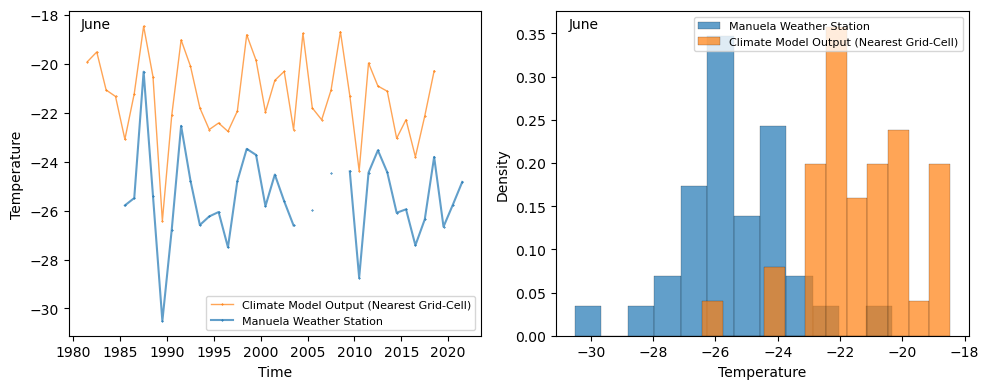

In [13]:
month = 6 
station = 'Manuela'

fig, axs = plt.subplots(1, 2, figsize=(10, 4), dpi=100)

ax = axs[0]
ds_climate_nearest_stacked.sel(nearest_station = station).where(ds_climate_nearest_stacked['month']==month,drop=True)['temperature'].plot(
                                                                                                                                x='t',
                                                                                                                                ax=ax,
                                                                                                                                hue='station',
                                                                                                                                alpha=0.7,
                                                                                                                                label='Climate Model Output (Nearest Grid-Cell)',
                                                                                                                                marker='x',
                                                                                                                                ms=1,
                                                                                                                                color='tab:orange',
                                                                                                                                linewidth=1.0)
ds_aws.sel(station = station).where(ds_aws['month']==month,drop=True)['temperature'].plot(ax=ax,
                                                                                                hue='station',
                                                                                                alpha=0.7,
                                                                                                label=f'{station} Weather Station',
                                                                                                marker='x',
                                                                                                ms=1,
                                                                                                color='tab:blue',
                                                                                                linewidth=1.5)

ax.annotate('June',xy=(0.03,0.95),xycoords='axes fraction')
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)#,rotation = 90)
ax.set_ylabel('Temperature')
ax.set_xlabel('Time')
ax.legend(fontsize=8)
ax.set_title('')

ax=axs[1]
ds_aws.sel(station=station).where(ds_aws['month']==month,drop=True).to_dataframe()[['temperature']].hist(bins=12,
                                         ax=ax,
                                         edgecolor='k',
                                         linewidth=0.2,
                                         grid=False,
                                         density=1,
                                         alpha=0.7,
                                         label = f'{station} Weather Station',
                                         )
ds_climate_nearest_stacked.sel(nearest_station=station).where(ds_climate_nearest_stacked['month']==month,drop=True).to_dataframe()[['temperature']].hist(bins=12,
                                         ax=ax,
                                         edgecolor='k',
                                         linewidth=0.2,
                                         grid=False,
                                         density=1,
                                         alpha=0.7,
                                        label = 'Climate Model Output (Nearest Grid-Cell)',
                                         )
ax.annotate('June',xy=(0.03,0.95),xycoords='axes fraction')
ax.set_title('')
ax.set_xlabel('Temperature')
ax.set_ylabel('Density')
ax.legend(fontsize=8)

plt.tight_layout()
plt.show()


It's clear in the June time series comparison that the climate model performs well at capturing the yearly variability (beyond just seasonality) and is highly correlated with the weather station output. However, there's a clear bias in the mean of approximately 4°. The PDF for both time series is well represented by a Gaussian distribution and so we can meaningfully define bias with respect to differences in the mean and variance of the two time series. In the rest of this notebook we'll focus on just evaluating and correcting bias in the June temperature for simplicity. 

### Pairplots

Since we're interested in evaluating bias in the mean and variance of the June time series, it's useful to think about predictors that have an influence on these metrics. The two most obvious predictors are elevation and latitude, both of which have well-understood physical justification for the impact on the mean temperature.  

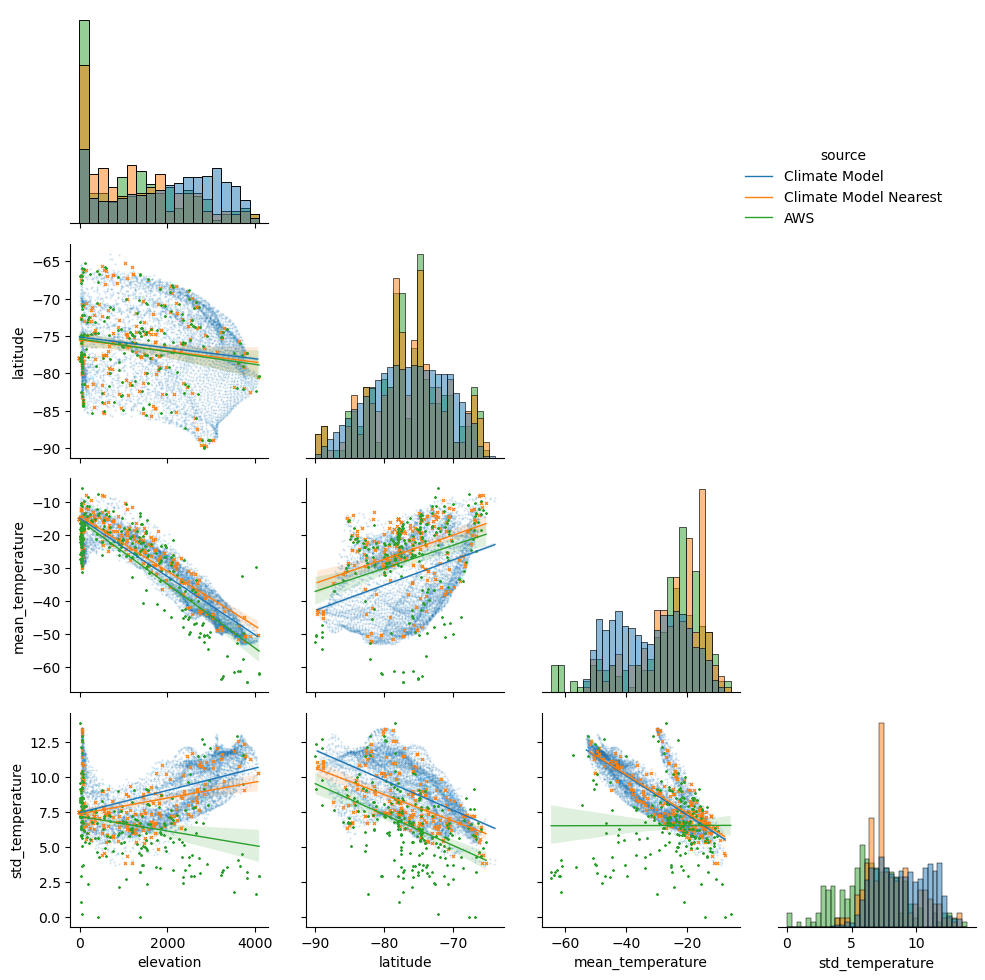

In [67]:
# Transforming data for plotting with seaborn PairGrid 
ds_aws['mean_temperature'] = ds_aws['temperature'].mean('t')
ds_aws['std_temperature'] = ds_aws['temperature'].std('t')
ds_climate_stacked['mean_temperature'] = ds_climate_stacked['temperature'].mean('time')
ds_climate_stacked['std_temperature'] = ds_climate_stacked['temperature'].std('time')
ds_climate_nearest_stacked['mean_temperature'] = ds_climate_nearest_stacked['temperature'].mean('time')
ds_climate_nearest_stacked['std_temperature'] = ds_climate_nearest_stacked['temperature'].std('time')

vars = ['elevation','latitude','mean_temperature','std_temperature']
df_climate = ds_climate_stacked[vars].to_dataframe()[vars].reset_index(drop=True)
df_climate_nearest = ds_climate_nearest_stacked[vars].to_dataframe()[vars].reset_index(drop=True)
df_aws = ds_aws[vars].to_dataframe()[vars].reset_index(drop=True)
df_climate['source'] = 'Climate Model'
df_climate_nearest['source'] = 'Climate Model Nearest'
df_aws['source'] = 'AWS'
df_combined = pd.concat([df_climate,df_climate_nearest,df_aws],axis=0).reset_index(drop=True)

# Plotting PairGrid with regression lines
g = sns.PairGrid(df_combined, hue='source',diag_sharey=False, corner=True)

reg_kws = {'scatter': False, 'line_kws':{'linewidth':1}}
g.map_lower(sns.regplot,**reg_kws)
g.add_legend(bbox_to_anchor=(0.8,0.8),markerscale=3)

g.hue_kws = {'marker':['+','x','*'],'s':[2,5,2],'alpha':[0.2,1,1]}
scatter_kws = {'linewidth':0.8}
g.map_lower(plt.scatter,**scatter_kws)

hist_kws = {'common_norm':False,'stat':'density'}
g.map_diag(sns.histplot,**hist_kws)

# g.add_legend(bbox_to_anchor=(0.8,0.8),markerscale=3)


The pairplots bring up some interesting features:
- Clear relationship between mean temperature with elevation and latitude. This relationship is fairly consistent for the AWS and climate model output.
- Apparent relationship between the standard deviation in temperature with elevation and latitude. Although, the relationship with elevation appears inconsistent between the AWS and climate model output. 
- Minimal difference is shown in the pairwise relationships shown for all the climate model output compared with just the nearest grid-cells to the AWS sites. Although, comparisons of the histograms show that the AWS sites are not a particularly representative sample of the whole Antarctic region (higher proportion of sites at zero elevation, clusters of sites at particular locations and so latitudes, dissproportionality high number of sites at regions with relatively high mean temperatures and relatively low standard deviations).
- Behaviour of relationship between elevation with mean temperature and standard deviation in temperature appears quite different at zero elevation sites. (This could be linked with various factors such as the impact of the nearby sea on zero elevation sites) 

### Maps of mean temperature, standard deviation and empirically computed bias at AWS locations.